In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np
from sklearn import preprocessing, neighbors, svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
import pickle
# df = pd.read_csv('data/2020 Line 280 AVL report.csv')
df = pd.read_csv('data/2020 Line 280 AVL allscripts.csv')
df['Actual Depart Hour'] = df['Actual Depart'].str.split(':',expand=True)[0]
df['Actual Depart Hour'] = df['Actual Depart Hour'].astype(int)
df['Transit Date Month'] = df['Transit Date'].str.split('/',expand=True)[0]
df['Transit Date Month'] = df['Transit Date Month'].astype(int)

C:\Users\Jai\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


C:\Users\Jai\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Jai\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Jai\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

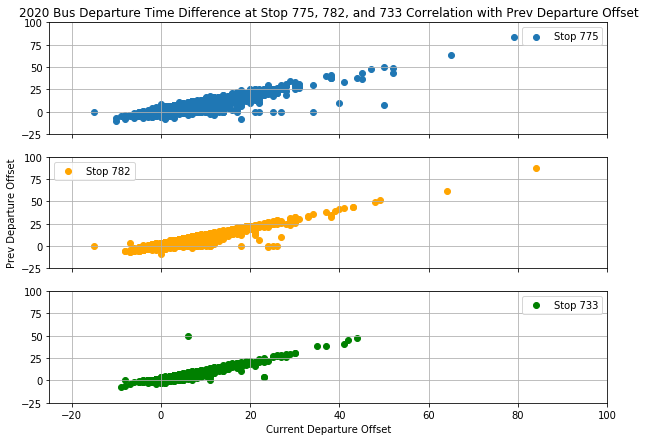

0.7148247815857964

In [5]:
stopactual = df.loc[df['Bus Stop ID'] == 775]
stopactual['Difference (Minutes)'] = stopactual['Difference (Minutes)'].astype(int)
stopactual['Prev Departure Offset'] = stopactual['Prev Departure Offset'].astype(int)

f=plt.figure(figsize=(10,7))

ax1=f.add_subplot(311)
ax1.set_xlim(left = -25,right=100)
ax1.set_ylim(bottom=-25,top=100)
ax1.set(Title="2020 Bus Departure Time Difference at Stop 775, 782, and 733 Correlation with Prev Departure Offset")
# plt.ylim(0,15)
ax1.scatter(stopactual['Difference (Minutes)'], stopactual['Prev Departure Offset'], label = 'Stop 775')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.legend()
plt.grid()


stopactual = df.loc[df['Bus Stop ID'] == 782]
stopactual['Difference (Minutes)'] = stopactual['Difference (Minutes)'].astype(int)
stopactual['Prev Departure Offset'] = stopactual['Prev Departure Offset'].astype(int)

ax2=f.add_subplot(312, sharex=ax1, sharey=ax1)
ax2.scatter(stopactual['Difference (Minutes)'], stopactual['Prev Departure Offset'], label = 'Stop 782', color='orange')
plt.setp(ax2.get_xticklabels(), visible=False)
plt.legend()
plt.grid()


stopactual = df.loc[df['Bus Stop ID'] == 733]
stopactual['Difference (Minutes)'] = stopactual['Difference (Minutes)'].astype(int)
stopactual['Prev Departure Offset'] = stopactual['Prev Departure Offset'].astype(int)

ax3=plt.subplot(313, sharex=ax1, sharey=ax1)
ax3.scatter(stopactual['Difference (Minutes)'], stopactual['Prev Departure Offset'], label = 'Stop 733', color='green')
plt.legend()
plt.grid()

ax3.set(xlabel="Current Departure Offset")
ax2.set(ylabel="Prev Departure Offset")

locs, labels = plt.xticks() 



plt.show()

df['Difference (Minutes)'].corr(df['Prev Departure Offset'])

In [3]:
# df1 = df.copy()
# df1 = df.loc[(df['Bus Stop ID'] == 775) | (df['Bus Stop ID'] == 782) | (df['Bus Stop ID'] == 733)]
df1 = df.loc[(df['Bus Stop ID'] != 177)]
df1 = df1.loc[(df1['Bus Stop ID'] != 738)]
df1 = df1.loc[(df1['Bus Stop ID'] != 2199)]
df1 = df1.loc[(df1['Bus Stop ID'] != 2384)]

df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week', \
    'Miles from Prior Time Point', 'Bus Stop ID'],prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_',\
        'Enc_Miles_', 'Enc_Stop_'])
# df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week', \
#     'Miles from Prior Time Point'],prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_',\
#         'Enc_Miles_'])
# df1 = pd.get_dummies(df1, columns=['Transit Date Month'],prefix=['Enc_Month_'])

# df1['Transit Date Month'] = df1['Transit Date'].str.split('/',expand=True)[0]
df1.fillna(value = -9999)
enc = OneHotEncoder(handle_unknown='ignore')

df1['Difference (Minutes)'] = df1['Difference (Minutes)'].astype(int)
df1['Prev Departure Offset'] = df1['Prev Departure Offset'].astype(int)
# df1['Transit Date Month'] = df1['Transit Date Month'].astype(int)

# df.replace('?', -99999, inplace=True) #sees -99999 as outlier, ignores it
df1.drop(['Transit Date', 'Vehicle #', 'Block #', 'Route #', 'Trip #', 'Direction',\
    'Pattern','Bus Stop Name', 'Stop Sequence','Latitude','Longitude','Scheduled Depart','Actual Depart',\
        'Reported Performance Results','Actual Arrival','Waivers',\
            'Dwell Time', 'Actual Run Time', 'Scheduled Operating Speed','Actual Operating Speed',\
                'Run Time Variance','Day Type','Time Period', 'Scheduled Run Time',\
                        'Scheduled Depart DateTime', 'Actual Depart DateTime', \
                            'Same Stop Prev Trip Departure Offset'\
                                ], 1, inplace=True)
# print(df1.head)
# pd.to_numeric(df1['Actual Operating Speed'], errors='coerce')
X = np.array(df1.drop(['Difference (Minutes)'],1)) #using everything except class to train
Y = np.array(df1['Difference (Minutes)']) #class is the final result obviously


filename = 'models/2019_lr_sgd_model_9_15.sav'
lr_sgd = pickle.load(open(filename, 'rb'))

scores = cross_val_score(lr_sgd, X, Y, cv=5)

print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


[0.7662462  0.60895257 0.56838206 0.59873046 0.64370675]
0.64 accuracy with a standard deviation of 0.07


Wall time: 1.03 s


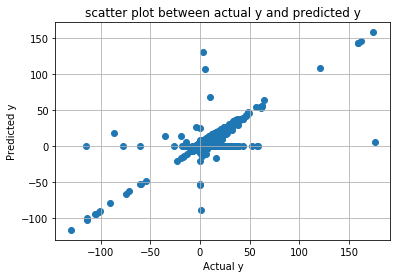

Mean Squared Error : 9.52382202622382
Mean Absolute Error : 1.1435613498656996
[0.70247472 0.62980015 0.56922267 0.78278695 0.74770636]
0.69 accuracy with a standard deviation of 0.08


In [4]:
# df1 = df.copy()
# df1 = df.loc[(df['Bus Stop ID'] == 775) | (df['Bus Stop ID'] == 782) | (df['Bus Stop ID'] == 733)]
df1 = df.loc[(df['Bus Stop ID'] != 177)]
df1 = df1.loc[(df1['Bus Stop ID'] != 738)]
df1 = df1.loc[(df1['Bus Stop ID'] != 2199)]
df1 = df1.loc[(df1['Bus Stop ID'] != 2384)]

df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week', \
    'Miles from Prior Time Point', 'Bus Stop ID'],prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_',\
        'Enc_Miles_', 'Enc_Stop_'])
# df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week', \
#     'Miles from Prior Time Point'],prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_',\
#         'Enc_Miles_'])
# df1 = pd.get_dummies(df1, columns=['Transit Date Month'],prefix=['Enc_Month_'])

# df1['Transit Date Month'] = df1['Transit Date'].str.split('/',expand=True)[0]
df1.fillna(value = -9999)
enc = OneHotEncoder(handle_unknown='ignore')

df1['Difference (Minutes)'] = df1['Difference (Minutes)'].astype(int)
df1['Prev Departure Offset'] = df1['Prev Departure Offset'].astype(int)
# df1['Transit Date Month'] = df1['Transit Date Month'].astype(int)

# df.replace('?', -99999, inplace=True) #sees -99999 as outlier, ignores it
df1.drop(['Transit Date', 'Vehicle #', 'Block #', 'Route #', 'Trip #', 'Direction',\
    'Pattern','Bus Stop Name', 'Stop Sequence','Latitude','Longitude','Scheduled Depart','Actual Depart',\
        'Reported Performance Results','Actual Arrival','Waivers',\
            'Dwell Time', 'Actual Run Time', 'Scheduled Operating Speed','Actual Operating Speed',\
                'Run Time Variance','Day Type','Time Period', 'Scheduled Run Time',\
                        'Scheduled Depart DateTime', 'Actual Depart DateTime', \
                            'Same Stop Prev Trip Departure Offset'\
                                ], 1, inplace=True)
# print(df1.head)
# pd.to_numeric(df1['Actual Operating Speed'], errors='coerce')
X = np.array(df1.drop(['Difference (Minutes)'],1)) #using everything except class to train
Y = np.array(df1['Difference (Minutes)']) #class is the final result obviously
np.nan_to_num(X)
np.nan_to_num(Y)
pd.isnull(X)
np.nan_to_num(X)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

# lr_sgd = SGDRegressor(penalty='elasticnet')
lr_sgd = SGDRegressor(loss='huber', penalty='elasticnet')
%time lr_sgd.fit(X_train, Y_train)

filename = 'models/2020_lr_sgd_model_9_15.sav'
pickle.dump(lr_sgd, open(filename, 'wb'))

plt.scatter(Y_test, lr_sgd.predict(X_test))
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
print('Mean Squared Error :',mean_squared_error(Y_test, lr_sgd.predict(X_test)))
print('Mean Absolute Error :',mean_absolute_error(Y_test, lr_sgd.predict(X_test)))

scores = cross_val_score(lr_sgd, X_test, Y_test, cv=5)

print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)
# ax.plot(X_train, clf.fit(X_train, Y_train).predict(X_train), lw=2)
# ax.scatter(X_train[clf.support_], Y_train[clf.support_], facecolor="none",s=50)
# # ax.scatter(X_test[np.setdiff1d(np.arange(len(X_test)),clf.support_)],
# #            Y_test[np.setdiff1d(np.arange(len(X_test)), clf.support_)],
# #            facecolor="none", edgecolor="k", s=50)


# fig.text(0.5, 0.04, 'data', ha='center', va='center')
# fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
# fig.suptitle("Support Vector Regression", fontsize=14)
# plt.show()